,ID сетевого моста,Степень
0,Степень сети,3
1,141,3
2,131,3
3,121,3
4,111,5
5,232,8
6,231,3
7,222,3
8,221,3
9,211,7


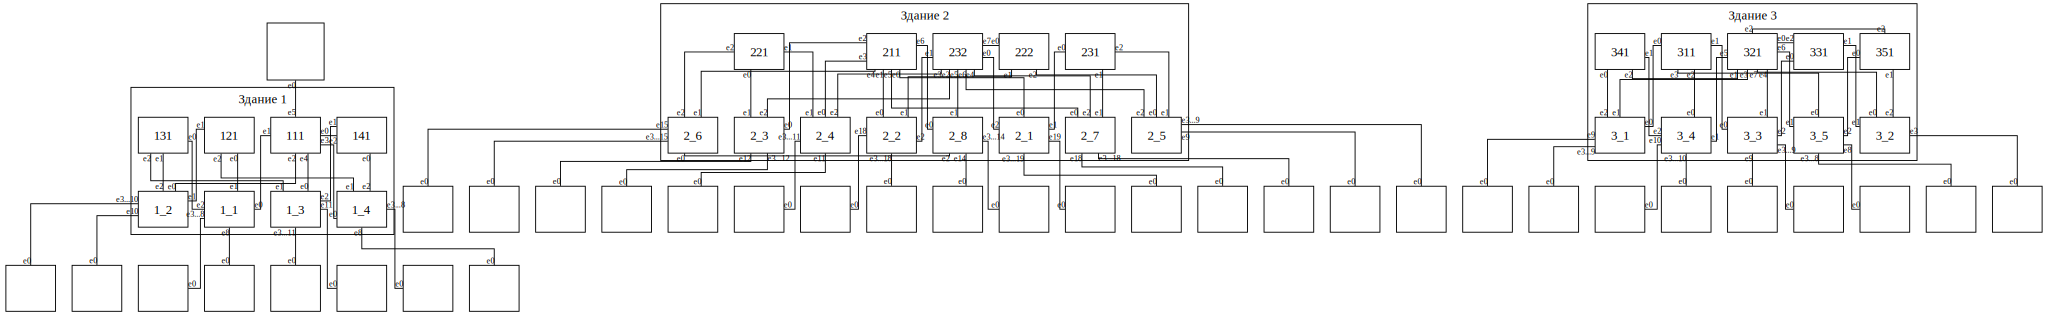

In [126]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from networkx.algorithms.connectivity import local_node_connectivity
from networkx.algorithms.flow import shortest_augmenting_path
import pygraphviz as pgv
from matplotlib import image as mpimg
import itertools

adj1={"111":["1_1","1_2"],"121":['1_2','1_4'],"131":["1_1","1_3"],"141":["1_3","1_4"]}
adj2={"211":['2_1','2_2','2_3','2_4','2_6','2_7','2_8'],'221':['2_3','2_4'],
    '222':['2_2','2_5'],'231':['2_1','2_5','2_7'],'232':['2_8']}
adj3={'311':['3_1','3_3','3_4','3_5'],'321':['3_2'],
    '331':['3_3'],'341':['3_1','3_4'],'351':['3_2','3_5']}
number={'1_1':5,'1_2':7,'1_3':8,'1_4':5,'2_1':16,'2_2':15,'2_3':9,'2_4':8,'2_5':6,'2_6':12,'2_7':15,'2_8':11,'3_1':6,'3_2':1,'3_3':6,'3_4':7,'3_5':5}

Gt={1:nx.Graph(adj1),2:nx.Graph(adj2),3:nx.Graph(adj3)}
for x in Gt:
    p=nx.k_edge_augmentation(Gt[x],3)
    Gt[x].add_edges_from(p)
G=nx.Graph()
G=Gt[1]
for x in Gt:
    G=nx.compose(Gt[x],G)
# G.add_edges_from([['111','211'],['121','221'],['131','231']]) #connection between 1 and 2
# G.add_edges_from([['311','211'],['321','221'],['331','231']]) #connection between 3 and 2
ed=G.edges()
for x in ed:
    G[x[0]][x[1]]['weight']=1
    
G1=G.copy()
G=nx.nx_agraph.to_agraph(G)
# G=pgv.AGraph(str(G)[7:],strict=False)

### Grouping
from operator import itemgetter
from itertools import groupby

nodes=G.nodes()
nodes.sort(key=itemgetter(0))
nodes=[[x for x in g] for k,g in groupby(nodes,key=itemgetter(0))]
all_common=[]
all_rule=[]
for k,n in zip(range(3),nodes):
    A=G.add_subgraph(n,name=f'cluster{k}',label=f'Здание {k+1}')
    rule=[x for x in n if '_' not in x]
    all_rule.extend(rule)
    A.add_subgraph(rule,name=f's{k+5}',rank='same')
    common=[x for x in n if '_'  in x]
    all_common.extend(common)
    A.add_subgraph(common,name=f's{k+10}',rank='same')
G.graph_attr['newrank']='true'

# rule=list((rule,name='s89',rank='same')

###Displaying degree of nodes
net_degree=pd.DataFrame({'ID сетевого моста':[],'Степень':[]})
for y in G.nodes():
    if y in all_common:
        continue
    net_degree.loc[-1]=[y,len(G.edges(y))]
    net_degree.index+=1
    net_degree = net_degree.sort_index()
    # print(x,y,len(G.adj[y]))
net_degree.loc[-1]=['Степень сети',net_degree['Степень'].min()]
net_degree.index+=1
net_degree = net_degree.sort_index()
display(net_degree)
net_degree.to_excel('output_sheet.xlsx')

for x in G:
    n=G.get_node(x)
    n.attr["shape"] = "box"
    # n.attr['fontcolor']='blue'
    n.attr['labelfontsize']=4
    n.attr["imagescale"] = "true"
    n.attr["image"] = 'icons8-switch-50.png'
G.add_edge('s','111')

n=G.get_node('s')
n.attr['shape']='box'
n.attr['label']=''
n.attr['image']='icons8-router-symbol-80.png'


net=[]
nodes=G.nodes()
for x in nodes:   
    e=0
    for y in G.edges(x):
        if y[0]==x:
            j=G.get_edge(*y)
            j.attr['taillabel']=f'e{e}'
            j.attr['labelfontsize']=9
            e+=1
        else:
            j=G.get_edge(*y)
            j.attr['headlabel']=f'e{e}'
            j.attr['labelfontsize']=9
            e+=1
    if x in all_common:
        net.extend([f'{x}_1'])
        G.add_edge(x,f'{x}_1')
        j=G.get_edge(x,f'{x}_1')
        if number[x]>=2:
            j.attr['taillabel']=f'e{e}...{e+number[x]}'
            j.attr['headlabel']=f'e0'
            j.attr['labelfontsize']=9
        else:
            j.attr['taillabel']=f'e{e}'
            j.attr['headlabel']=f'e0'
            j.attr['labelfontsize']=9
        if number[x]>=2:
            e+=number[x]
            G.add_edge(x,f'{x}_2')
            j=G.get_edge(x,f'{x}_2')
            j.attr['taillabel']=f'e{e}'
            j.attr['headlabel']=f'e0'
            j.attr['labelfontsize']=9
            net.extend([f'{x}_2'])
for x in net:
    n=G.get_node(x)
    n.attr["shape"] = "box"
    n.attr['fontcolor']='blue'
    n.attr['label']=''
    n.attr["imagescale"] = "true"
    n.attr["image"] = 'icons8-my-computer-64.png'


G.graph_attr['splines']='ortho'

G.layout('dot')
G.draw('output.png')

G


In [8]:
# # print(nx.edge_connectivity(n))

# image = mpimg.imread("output.png")
# plt.imshow(image)
G1

In [30]:
def deicster(m,st):
  ar={x:[np.inf,[]] for x in m.nodes()}
  # print(ar)
  se=set()
  ar[st][0]=0
  while (se != set(m.nodes())):
    # choosing node
    s={x:y for x,y in ar.items() if x not in se}
    a=min(s,key=s.get)
    weicur=ar[a][0]
    # print("current node:",a)
    #getting weights of neighbors
    for x in m[a].items():
      if x[0] in se:
        continue
      # print('checking',x[0])
      name=x[0]
      weight=x[1]['weight']
      # print('sum weight', weicur+weight)
      # refreshing weighs
      if ar[name][0]>weicur+weight:
        ar[name][0]=weicur+weight
        # print(ar[a][1])
        ar[name][1]=ar[a][1]+[a]
        # print('changed')
        # print(ar)
    se.add(a)
    # print(se)
  return ar

ar=deicster(G1, '111')
cost=[x[0] for x in ar.values()]
path=[x[1] for x in ar.values()]
net_degree=pd.DataFrame({'ID сетевого моста':ar.keys(),'Путь':path,'Переходы':cost})
net_degree.to_excel('output_sheet1.xlsx')
net_degree

,ID сетевого моста,Путь,Переходы
0,311,"[111, 211]",2
1,321,"[111, 1_1, 121, 221]",4
2,331,"[111, 1_1, 131, 231]",4
3,341,"[111, 211, 311, 3_1]",4
4,351,"[111, 211, 311, 3_5]",4
5,3_1,"[111, 211, 311]",3
6,3_3,"[111, 211, 311]",3
7,3_4,"[111, 211, 311]",3
8,3_5,"[111, 211, 311]",3
9,3_2,"[111, 1_1, 121, 221, 321]",5


,A1,B2,C3,D4,E5,F6
A1,0,1,0,1,1,0
B2,1,0,0,1,1,1
C3,0,0,0,0,0,1
D4,1,1,0,0,0,1
E5,1,1,0,0,0,1
F6,0,1,1,1,1,0


In [64]:
df=pd.read_csv('/home/we/Desktop/txt 2.txt',sep='\t',index_col=0)

G=nx.from_numpy_array(df.to_numpy())
G=nx.relabel_nodes(G,{x:y for x,y in zip(range(6),df.index)})
G.nodes()
tables={}
for x in df.index:
    ar=deicster(G, x)
    cost=[x[0] for x in ar.values()]
    path=['' if len(x[1])==0 else y if len(x[1])==1 else x[1][1] for x,y in zip(ar.values(),ar.keys())]
    tables[x]=pd.DataFrame({'Маршрутизатор':ar.keys(),'Переходы':cost,'Отправка через узел':path})
for x in tables:
    tables[x].to_excel(f'{x}_sheet.xlsx')
    display(tables[x])

,Маршрутизатор,Переходы,Отправка через узел
0,A1,0,
1,B2,1,B2
2,C3,3,B2
3,D4,1,D4
4,E5,1,E5
5,F6,2,B2


In [56]:
G=nx.from_numpy_array(df.to_numpy())
G=nx.relabel_nodes(G,{x:y for x,y in zip(range(6),df.index)})
G.nodes()
tables={}
for x in df.index:
    ar=deicster(G, x)
    cost=[x[0] for x in ar.values()]
    path=[x[1] for x in ar.values()]
    tables[x]=pd.DataFrame({'Маршрутизатор':ar.keys(),'Переходы':cost,'Путь':path})
tables['A1']


big_table=pd.DataFrame({'Маршрутизатор':[],'Переходы':[],'Путь':[]})
for x in df.index:
    big_table=pd.concat([big_table,tables[x]])
b=big_table[['Путь','Переходы']].iloc[big_table['Переходы'].idxmax(),:]
pd.DataFrame(b).T


,Путь,Переходы
2,"[A1, B2, F6]",3.0
